# Climate Change Belief Classification

## Contents: <a class="anchor" id="contents-bullet"></a>
- [Introduction](#first-bullet)
- [Imports](#second-bullet)
- [Loading Data](#third-bullet)
- [Data Definitions](#fourth-bullet)
- [Data Cleaning](#fifth-bullet)
- [Feature Engineering](#sixth-bullet)
- [Text Selection](#seventh-bullet)
- [Exploratory Data Analysis](#eigth-bullet)
- [Modelling](#ninth-bullet)
- [Conclusion](#tenth-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

### Context
Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

### Problem statement 
With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Objective
- __Competition:__ [Climate Change Belief Analysis](https://www.kaggle.com/c/climate-change-belief-analysis)
- __Determine:__ How the public perceives climate change and wheter or not they believe it is a threat
- __Classify:__ Individuals by belief in climate change based on novel tweet data
- __Evaluation:__ Weighted F1-Score
- __Kernel Workflow:__ Data -> Features(EDA) -> Comparison(EDA) -> Model

### Evaluation Metric

**weighted f1-score**

The traditional f1-score is the harmonic mean between precision and recall:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/3607c634303f2fd8b69ca4f9d97a491c45083cc5"
     />

The F1 Scores are calculated for each label (`2`, `1`, `0`, `-1`) and then their average is weighted by support - being the number of true instances for each label. In other words, the f1-score for each label is weighted based on it's proportion of TN and TP in the  sample.

Just like the f1-score, the weighted f1 score will be a number between 0 and 1 where perfect precision and recall occurs at 1.

### Contributors

- Ebrahim Noormahomed - Supervisor
- Zanele Gwamanda
- Stanley Machuene Kobo
- Rirhandzu Mahlaule
- Kgaogelo Mamadi
- Bulelani Nkosi
- Titus Ndondo


## Imports <a class="anchor" id="second-bullet"></a>
[back to top](#contents-bullet)

#### Experiments
!pip install comet_ml

#### Dependencies
- *!pip install textblob*
- *!pip install wordcloud*
- *!pip install twython

In [1]:
# Setting up experiments
from comet_ml import Experiment

# Linking to Comet
experiment = Experiment(api_key='tvx43aEjuXWoGnkxiQOaNjXD7',
                       project_name='classification-predict',
                       workspace='en2-jhb')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/en2-jhb/classification-predict/b22c5743e4414afe989b93ceef9c78b1



In [2]:
# Data wrangling libraries
import pandas as pd
import numpy as np
from collections import Counter
import re

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from spacy import load
from textblob import TextBlob

# Download NLTK Dependencies
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

# Load spacy
# nlp = load('en_core_web_sm')

# Feature Preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Evaluating Model Performance
from sklearn.metrics import f1_score

# Storing Models and Vectorizers
import pickle

# Settings
sns.set()
%matplotlib inline

## Loading Data <a class="anchor" id="third-bullet"></a>
[back to top](#contents-bullet)

#### Load the training dataset and inspecting the dataset.

In [3]:
# load the datasets
train_data = pd.read_csv('./resources/datasets/train.csv')
test_data = pd.read_csv('./resources/datasets/test.csv')
sample_data = pd.read_csv('./resources/datasets/sample_submission.csv')

# check the number of rows and columns of the data
print (f"There are {train_data.shape[0]} rows and {train_data.shape[1]} columns in the training set.")
print (f"There are {test_data.shape[0]} rows and {test_data.shape[1]} columns in the test set.")

There are 30759 rows and 3 columns in the training set.
There are 10546 rows and 2 columns in the test set.


In [4]:
train_data.head(3)

,sentiment,message,tweetid
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553
1,-1,All the biggest lies about climate change and ...,925046776553529344
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30759 entries, 0 to 30758
Data columns (total 3 columns):
sentiment    30759 non-null int64
message      30759 non-null object
tweetid      30759 non-null int64
dtypes: int64(2), object(1)
memory usage: 721.0+ KB


After inspecting the data, the following is noted:
1. There does not appear to be any missing data - This will be confirmed later
2. Sentiment is `int64` although it is a categorical data type
3. Int64 is an inefficient int size for the size of the numbers stored. `int16` will be far more memory efficient

## Data Definitions <a class="anchor" id="fourth-bullet"></a>
[back to top](#contents-bullet)

### Description
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

This dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

### Data types

**Categorical**
- *sentiment*: (Target) Sentiment of tweet labeled `-1`,`0`,`1`, and`2` representing `'Anti'`,`'Neutral'`,`'Pro'`, and`'News'` respectively.

**Numeric**
- *tweetid*:  Unique tweet id

**Unstructured**
 - *message*: Tweet body used for training



[back to top](#contents-bullet)

## Data Cleaning <a class="anchor" id="fifth-bullet"></a>
In this section we do further cleaning of the tweets. Tweets often have urls, hashtags and handles that we may want to remove from the tweets if we are to properly analyse the tweets and get insights. However, in certain cases we may also want to do further analysis such tweet attributes. So instead of completely throwing them away, we'll just create new columns in our dataframe to store them. The following tasks are meant to acieve that purpose. First we do a quick check of any missing tweets or tweets with empty strings.

In [6]:
# Here is an example tweet selected randomly
tweet = train_data.loc[771, 'message']
tweet

'GMOs are the Lefties climate change. Science be damned. We all have our blinders. https://t.co/PYR6avuDd7'

#### investigate missingness and empty strings

In [7]:
count = 0
for i,s,m,tid in train_data.itertuples():
    if type(m)==str:
        if str(m).isspace():
            count += 1

print (f"There are {train_data['message'].isnull().sum()} missing values and {count} empty strings in the training set.")

There are 0 missing values and 0 empty strings in the training set.


#### map the target to actual labels
The target is provided as the numbers -1, 0, 1, and 2. We want to map these to their actual string for example "Anti" for -1. The rest map as follows: 0:'Neutral', 1:'Pro', 2:'News'

In [8]:
target_map = {-1:'Anti', 0:'Neutral', 1:'Pro', 2:'News'}
train_data['target'] = train_data['sentiment'].map(target_map)

Write a function to convert the data types

In [9]:
def typeConvert(df):
    if 'sentiment' in df.columns:
        df['sentiment'] = df['sentiment'].astype('category')
    df['tweetid'] = df['tweetid'].astype('int16')
    return df

# train_data = typeConvert(train_data)

Here we write a user function that finds url like strings in the tweets and extracts them.

In [10]:
def findURLs(tweet):
    """
    return a string of all urls in a text
    
    Parameters
    ----------
        tweet (str): tweet containing urls
    Returns
    -------
        all_ (str): all urls in text
        
    """
    # create string to extract an url
    pattern = r'ht[t]?[p]?[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    # extract an url
    all_ = " ".join(re.findall(pattern,tweet))
    return all_

# example implementation
findURLs(tweet)

'https://t.co/PYR6avuDd7'

In [11]:
# finally implement the function in the train dataset
train_data['urls'] = train_data['message'].map(findURLs)

After extracting the urls there are two things we may do. We may remove them completely from the tweets. Another option, that we think is more plausible is to replace them with the string "urlweb". This will result in all tweet that have a url of any sort containing this value. This will minimise the loss of data we may incur by completely discarding them. Below we write a user function that does just that.

In [12]:
def strip_url(df):
    """
    removes all urls from a the DataFrame raw message and replaces them with "urlweb"
    Parameters
    ----------
        df (DataFrame): input dataframe
    Returns
    -------
        clean_df (DataFrame): output dataframe
    Examples
    --------
            |index|sentiment|message|tweetid
            |0    |-1       |https..|13442
        >>> strip_url(train)
            |index|sentiment|message|tweetid
            |0    |-1       |urlweb |13442
    """
    # copy the original DataFrame
    clean_df = df.copy()
    # create string to remove an url
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-@.&+]|[!*(),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    # create new string
    subs_url = r'urlweb'
    # replace an url with 'urlweb' string
    clean_df['message'] = clean_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return clean_df

# Transforming dataframe
train_data = strip_url(train_data)

See example of a randomly selected tweet with a url below.

In [13]:
tweet = train_data['message'][771]
tweet

'GMOs are the Lefties climate change. Science be damned. We all have our blinders. urlweb'

Again, we write a user function that find twitter handles and treats them the same way urls were treated above.

In [14]:
def findHandles(tweet):
    """
    returns a list of all handles in a tweet
     
    Parameters
    ----------
         tweet (str): text containing handles
    Returns
    -------
         handles (list): list of all handles
    Examples
    --------
        >>> findHandles("hi @SenBernieSanders, you will beat @realDonaldTrump")
            ['@SenBernieSanders','@realDonaldTrump']
    """
    # create an empty list
    handles = list()
    for token in tweet.split():
        if token.startswith('@'):
            handles.append(token) #.replace('@', '')
    return handles

# example implementation
findHandles(tweet)

[]

In [15]:
# finally implement the function across the training data
train_data['handles'] = train_data['message'].map(findHandles)

Similarly, we write another function that extracts hashtags from the tweet.

In [16]:
def findHashTags(tweet):
    """
     returns a list of all hashtags in a tweet
     Parameters
     ----------
        tweet (str): text containing hashtags
     Returns
     -------
        hash_tags (list): list of all hashtags
     Examples
     --------
        >>> findHashTags("Oil is killing the world renewables and EVS are the 
                                way the go! #EVs #GlobalWarming #Fossilfuels")
            ['#EVs', '#GlobalWarming', '#Fossilfuels']
     """
    # create an empty list
    hash_tags = list()
    for token in tweet.split():
        if token.startswith('#'):
            hash_tags.append(token)
    return hash_tags

# example implementation
findHashTags(tweet)

[]

Unfortunately our randomly selected tweet does not have any hashtags. Lets just go ahead and implement the fucntion across the training data.

In [17]:
# finally implement the function across the training data
train_data['hash_tags'] = train_data['message'].map(findHashTags)

After all this is done we've introduced three more columns in our training dataset. One for urls, another for handles and another for hashtags. In the next section, as we do more data cleaning, these tweet attributes can be removed and we will be comfortable with that because we've already stored them separately.

In [18]:
train_data.head(3)

,sentiment,message,tweetid,target,urls,handles,hash_tags
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[]
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[]
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305,Anti,https://t.co/1dIOrfkslx,[@forbes],"[#Fraud, #Obamacare, #tcot, #teaparty, #pjnet]"


In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30759 entries, 0 to 30758
Data columns (total 7 columns):
sentiment    30759 non-null int64
message      30759 non-null object
tweetid      30759 non-null int64
target       30759 non-null object
urls         30759 non-null object
handles      30759 non-null object
hash_tags    30759 non-null object
dtypes: int64(2), object(5)
memory usage: 1.6+ MB


# Feature engineering <a class="anchor" id="sixth-bullet"></a>
[back to top](#contents-bullet)

This section is dedicated to further cleaning the tweets and formating them in such a way that they can be fed into a machine learning model. The first step in that regard is to remove punctuation and other characters that introduce noise to the tweets such as brackets, curly braces, question marks etc. Next we implement tokenization. This is a common technique in text analytics that takes a sentence or text and transforms it into a list of words instead. Text data formatted this way can then be fed into machine learning model using a Bag of Words (BOC) approach. More will be explained on what BOC is all about in the predictive modelling section later. The next step will then be to remove stop words. These are words such as (and, is, I, am etc) that do not necessarily provide any information about sentiments because they occur too frequently in language. Lastly we will lemmatize the words. Lemmatization is the process of reducing words to their root form for example the root form of falling is "fall". This has the advantage of reducing the number of unique words in the text data's vocabulary and most importantly it allows the machine learning models we build later to learn generalised patterns by identifying "falling" and "fall" as the same word rather than two different words. In the following tasks we write functions that implement the above outlined preprocessing.

In [20]:
# For interest sake we print out the example tweet again
tweet

'GMOs are the Lefties climate change. Science be damned. We all have our blinders. urlweb'

The function below takes as input a single tweet and removes punctuation and other uncommon characters in the tweet. See example implementation below and how the punctuation has been removed. 

In [21]:
def removePunctuation(tweet):
    """
    akes as input a single tweet and removes punctuation and other uncommon characters in the tweet.
    See example implementation below and how the punctuation has been removed.
    Parameters
    ----------
        tweet (str): string containing punctuation to be removed
    Returns
    -------
        clean_tweet (str): string without punctuation
    Examples
    --------
        >>> removePunctuation("Hey! Check out this story: urlweb. He doesn't seem impressed. :)")
            "Hey Check out this story urlweb He doesn't seem impressed"
    """    
    # first remove line spaces
    clean_tweet = tweet.replace('\n', ' ')
    
    # substitute digits within text with an empty strring
    clean_tweet = re.sub('\w*\d\w*', ' ', clean_tweet)
    
    # remove punctuation
    # some of the character removed here were determined by visually inspecting the text
    clean_tweet = re.sub(r'[:;.,_()/\{}"?\!&¬¦ãÃâÂ¢\d]', '', clean_tweet) 
    
    # return cleaner tweet
    return clean_tweet

# example implementation
tweet = removePunctuation(tweet)
tweet

'GMOs are the Lefties climate change Science be damned We all have our blinders urlweb'

In [22]:
# finally implement the function across the training data
train_data['tweets'] = train_data['message'].map(removePunctuation)

Now tokenize the tweet using NLTK's TweetTokenizer class. This class was designed specifically for twitter data. As such in addition to allowing us to lower case the tokenized tweets it also allows us to removed handles by setting the argument strip_handles to True. Remember we can remove these because we have them stored in a separate column anyway. See example implementation for the expected output.

In [23]:
def tweetTokenizer(tweet):
    """
    tokenizes and strips handles from twitter data
    Parameters
    ----------
        tweet (str): string to be tokenized
    Returns
    -------
        tokenized_tweet (list): list of tokens in tweet
    Examples
    --------
        >>> tweetTokenizer("Read @swrightwestoz's latest on climate change insurance amp lending featuring APRA speech and @CentrePolicyDev work urlweb")
            ['read',
             'latest',
             'on',
             'climate',
             'change',
             'insurance',
             'amp',
             'lending',
             'featuring',
             'apra',
             'speech',
             'and',
             'work',
             'urlweb']
    """
    tokenizer = TweetTokenizer(preserve_case = False, strip_handles = True)
    tokenized_tweet = tokenizer.tokenize(tweet)
    return tokenized_tweet

tokenized_tweet = tweetTokenizer(tweet)
tokenized_tweet

['gmos',
 'are',
 'the',
 'lefties',
 'climate',
 'change',
 'science',
 'be',
 'damned',
 'we',
 'all',
 'have',
 'our',
 'blinders',
 'urlweb']

Note that single character words such as "s" and "'" will also need to be removed. We do that in the following task.

In [24]:
# finally implement the function across the training data
train_data['tweets'] = train_data['tweets'].map(tweetTokenizer)

Here we remove the stop words. Note that the list of stopwords provided by NLTK can be extended simply by concatenating a list of the additional words. Here we added the word "amp". More words can be added but this will suffice for now.

In [25]:
def removeStopWords(tokenized_tweet):
    """
    removes stop words and punctation relics
    Parameters
    ----------
        tokenized_tweet (list): list of tokens to be cleaned
    Returns
    -------
        clean_tweet (list): list of tokens without stopwords
    Examples
    --------
        >>> removeStopWords(['read',
                            'latest',
                            'on',
                            'climate',
                            'change',
                            'insurance',
                            'amp',
                            'lending',
                            'featuring',
                            'apra',
                            'speech',
                            'and',
                            'work',
                            'urlweb'])
            ['read',
             'latest',
             'on',
             'climate',
             'change',
             'insurance',
             'amp',
             'lending',
             'featuring',
             'apra',
             'speech',
             'and',
             'work',
             'urlweb']
    """
    # initialising an empty list as container for the cleaned tweet
    clean_tweet = list()
    # iterating through all words in a list
    for token in tokenized_tweet:
        # checking if current word is not a stopword # also checking if the current word is a hash_tag # also checking if the current word has more than one character
        if token not in stopwords.words('english') + ['amp','rt'] and token.startswith('#') == False and len(token) > 1:
            clean_tweet.append(token)            
    # return the cleaner tweet
    return clean_tweet

# example implementation
clean_tweet = removeStopWords(tokenized_tweet)
clean_tweet

['gmos',
 'lefties',
 'climate',
 'change',
 'science',
 'damned',
 'blinders',
 'urlweb']

In [26]:
# finally implement the function across the training data
train_data['tweets'] = train_data['tweets'].map(removeStopWords)

Lastly, we do lemmatization. We utilise NLTK's WordNet Lemmatizer class.

In [27]:
def lemmatizeTweet(tweet):
    """
    tweet lemmatizer
    Parameters
    ----------
        tweet (list): tokens to be lemmatized
    Returns
    -------
        lemmatized_tweet (list): lemmatized list of tokens 
    Examples
        >>> lemmatizeTweet(['read',
                            'latest',
                            'on',
                            'climate',
                            'change',
                            'insurance',
                            'amp',
                            'lending',
                            'featuring',
                            'apra',
                            'speech',
                            'and',
                            'work',
                            'urlweb'])
            ['read',
             'latest',
             'climate',
             'change',
             'insurance',
             'lending',
             'featuring',
             'apra',
             'speech',
             'work',
             'urlweb']
    """
    lemmatized_tweet = list()
    lmtzr = WordNetLemmatizer()
    for token in tweet:
        lemmatized_tweet.append(lmtzr.lemmatize(token))
        
    return lemmatized_tweet

# example implementation
lemmatized_tweet = lemmatizeTweet(clean_tweet)
lemmatized_tweet

['gmos',
 'lefty',
 'climate',
 'change',
 'science',
 'damned',
 'blinder',
 'urlweb']

In [28]:
# finally implement the function across the training data
train_data['tweets'] = train_data['tweets'].map(lemmatizeTweet)

Having done all this preprocessing in the tweets we've added an extra column "tweets" to the dataset. These tweets have been removed of punctuation, tokenized (thus they are in list of words format), removed of stopwords and lemmatized. Ofcoarse we did not see lemmatization in action because our example tweet didn't particularly have words with lemmas. We just trust the process.

In [29]:
train_data.head(3)

,sentiment,message,tweetid,target,urls,handles,hash_tags,tweets
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[],"[funny, hell, canada, demand, gender, right, c..."
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[],"[biggest, lie, climate, change, global, warmin..."
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305,Anti,https://t.co/1dIOrfkslx,[@forbes],"[#Fraud, #Obamacare, #tcot, #teaparty, #pjnet]","[coming, revelation, global, warming, resemble..."


## Text Selection - Part 1 <a class="anchor" id="seventh-bullet"></a>
[back to top](#contents-bullet)

Usually the Data Science will include a section of feature selection. In Natural Language Processing however, we don't immediately have features. For example in the provided dataset has a single column whose entries are tweets. How do we get features? One such approach is the BOW model. Bag of Words is literally a Bag of Words. The Bag can be thought of as the `list` object in Python and the contents of that Bag/list are the words. The way this BOW is transformed to a set of features that are machine learning ready is as follows: 
1. All unique words in all tweets are extracted and mapped in a dataframe as column names. The whole sample of tweets remains as rows. 
2. For each row/tweet and for each column name/word we count the number of occurances of the word in the tweet and assign that as a value in the corresponding cell.

So a BOW creates as many columns as there unique words in the tweets combined, resulting in a sparse matrix (a matrix with many zero values because words generally occur infrequently in text).

Here we utilise a looping method to go through each of the tweets and extract the words and append them to a list. So the output "vocab" is a giant list with all words that occur atleast once in the tweets

In [30]:
def getVocab(df):
    """
    count total vocabulary from Dataframe message
    
    Parameters
    ----------
        df (DataFrame): input dataframe
    Returns
    -------
        vocab (list): list of all words that occur atleast once in the tweets 
    """
    vocab = list()
    for tweet in df:
        for token in tweet:
            vocab.append(token)
    return vocab

In [31]:
vocab = getVocab(df = train_data['tweets'])

Next we take the unique words and count them.

In [32]:
len(vocab), pd.Series(vocab).nunique()

(307605, 21338)

The total number of words is 159465 while 13882 are unique. This means our BOW sparse matrix would consist of 13883 columns. The number of rows would be equal to the number of tweets we have in the data. This is a big matrix. In practice it is common to remove infrequently occuring words, a process that can be viewed as doing feature selection of some sort. In the following task we attempt to do just that.

It makes sense to first investigate if there are any words that occur exclusively in one class. Such words, if they occur sufficiently, can be used to immediately distinguish between the classes. The code cell below attempts do that operation. The frequency computations are done per class and stored in a dictionary using a for loop operation.

In [33]:
word_frequency_dict = {}
for label in train_data['target'].unique():
    data = train_data[train_data['target'] == label]
    class_vocab = getVocab(data['tweets'])
    length_of_vocab = len(class_vocab)
    ordered_class_words = Counter(class_vocab).most_common()
    ordered_class_words_freq = list()
    for paired_tuple in ordered_class_words:
        word, count = paired_tuple
        word_frequency = round((count / length_of_vocab) * 100, 3)
        ordered_class_words_freq.append((word, word_frequency))
        word_frequency_dict[label] = ordered_class_words_freq
        
word_frequency_dict['Anti'][-5:]

[('philippine', 0.004),
 ('guaranteed', 0.004),
 ('experimental', 0.004),
 ('drug', 0.004),
 ('validated', 0.004)]

For example, displayed above are the top 5 most common words in the "Anti" sentiment group. Next we want to extract the words, the first value in the paired tuples displayed above, but we dont need all of them, some occur way too infrequently. The figure below shows the distribution of the frequencies. Most of them occur with frequencies close to zero percent. In the figure we've limited both the x and the y axis to show the relevant pasrts of the plot, see the code cell below. You can comment out the set_lim menthods to see the entire axis.

C:\Users\bulel\anaconda\envs\nlp_course\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


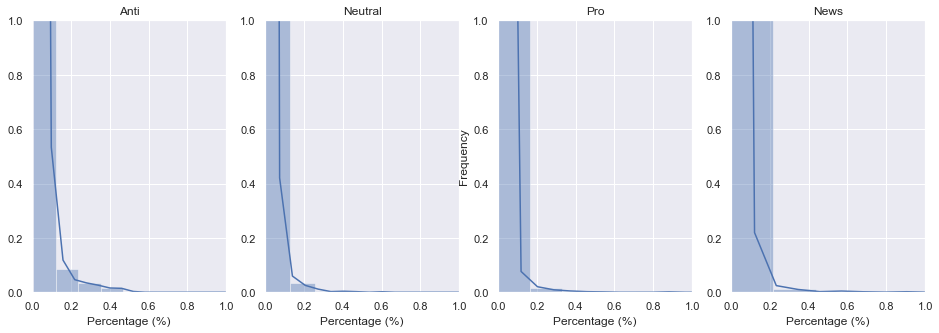

In [34]:
fig, axes = plt.subplots(1, 4, figsize = (16, 5))
for i, label in enumerate(train_data['target'].unique()):
    data = pd.DataFrame(word_frequency_dict[label])[1]
    g = sns.distplot(data, ax = axes[i])
    g.set_title(label)
    g.set_xlabel('Percentage (%)')
    if label == 'Pro':
        g.set_ylabel('Frequency')
    g.set_xlim(0, 1) # comment this
    g.set_ylim(0, 1) # comment this

Looking at the axis, however, we will choose a threshold frequency for a word to be kept. We choose 0.02 for now.

To identify infrequently occuring words, we start of by ordering the words in our vocabulary by frequency. Luckily we already have a giant list with our vocabulary from the previous task. So we untilise a python package known as Collections (already imported above). The package has a useful function "Counter". Takes as input a list of words, counts their occurance and returns an object with a method "most_common" that returns tuple pairs that display as below (for the 5 most common words).

In [35]:
frequency_threshold = 0.01
class_words = {}
for label, value in word_frequency_dict.items():
    words = list()
    for paired_tuple in value:
        word, freq = paired_tuple
        if freq > frequency_threshold:
            words.append(word)
    class_words[label] = words
    
class_words['News'][:5]

['urlweb', 'change', 'climate', 'trump', 'global']

For example, displayed above are the first 5 words extracted from the tuple pairs relating to the "News" sentiment group and meet the criteria of occuring more than 0.05% in the News tweets. Next we want to get words that are specific to each class by utilising sets. So we get a set of, for example, Pro words and subtract from that set a union set of the other 3 classes. See code cell below.

In [36]:
pro_spec_words = list(set(class_words['Pro']) - set(class_words['Neutral']).union(set(class_words['Anti'])).union(set(class_words['News'])))
neutral_spec_words = list(set(class_words['Neutral']) - set(class_words['Pro']).union(set(class_words['Anti'])).union(set(class_words['News'])))
anti_spec_words = list(set(class_words['Anti']) - set(class_words['Pro']).union(set(class_words['Neutral'])).union(set(class_words['News'])))
news_spec_words = list(set(class_words['News']) - set(class_words['Pro']).union(set(class_words['Neutral'])).union(set(class_words['Anti'])))

label_specific_words = dict(
    Pro = pro_spec_words, Neutral = neutral_spec_words, Anti = anti_spec_words, News = news_spec_words
    )
label_specific_words['Pro'][:5]

['fracking', 'towards', 'pretending', 'non-competiti', 'acknowledge']

For example, above displayed are 5 of the words that are specific to the Pro sentiment group. The number of unique words as found in the tweets are displayed below.

In [37]:
print(f" Pro: {len(pro_spec_words):{10}} \n Neutral: {len(neutral_spec_words):{6}} \n Anti: {len(anti_spec_words):{8}} \n News: {len(news_spec_words):{9}}")

 Pro:        156 
 Neutral:    211 
 Anti:      473 
 News:       302


Next we want to concatenate the class specific words and store them for later use.

In [38]:
class_specific_words = pro_spec_words + neutral_spec_words + anti_spec_words + news_spec_words
class_specific_words[:5], len(class_specific_words)

(['fracking', 'towards', 'pretending', 'non-competiti', 'acknowledge'], 1142)

To identify infrequently occuring words, we start of by ordering the words in our vocabulary by frequency, similar to the way we orderd them in the previous task per class. Luckily we already have a giant list with our vocabulary from an earlier task. So we utilise a python package known as Collections (already imported above). The package has a useful function "Counter". Takes as input a list of words, counts their occurance and returns an object with a method "most_common" that returns tuple pairs that display as below (for the 5 most common words).

In [39]:
ordered_words = Counter(vocab).most_common()
ordered_words[:5]

[('change', 23983),
 ('climate', 23946),
 ('urlweb', 20043),
 ('global', 7574),
 ('warming', 7033)]

Not surprisingly the words climate and change occur with highest frequency. The tweets are about climate change after all. Anyway, our intention is to keek the top n words, where n is the number of words we want to keep. Below we write a function that iterate through the paired tuples displayed above and returns a list of top n words. Function argument is n.

In [40]:
# Note, we set default n = 5000
# function to generate the top N of words
n = 5000
def topNWords(ordered_words, n = n):
    """
    count total vocabulary from Dataframe message
    
    Parameters
    ----------
        df (DataFrame): input dataframe
    Returns
    -------
        vocab (list): list of all words that occur atleast once in the tweets 
    """
    most_common = list()
    for word in ordered_words[:n]:
        most_common.append(word[0])
    return most_common

# implementing the function
top_n_words = topNWords(ordered_words)
top_n_words[:5]

['change', 'climate', 'urlweb', 'global', 'warming']

In [41]:
# show the count of uniques
pd.Series(top_n_words).nunique()

5000

Next we need a function that goes through the words in a tweet, determines if there are any words that are not in the top n words and removes them from the tweet and return the filtered tweet. Note that this operation should exclude the 762 class specific words determined above. See below.

In [42]:
tweet

'GMOs are the Lefties climate change Science be damned We all have our blinders urlweb'

In [43]:
def removeInfrequentWords(tweet, include):
    """
    Function that goes through the words in a tweet,
    determines if there are any words that are not in
    the top n words and removes them from the tweet
    and return the filtered tweet.
    Parameters
    ----------
        tweet (list): list tokens to be flitered
        top_n_words (int): number of tweets to keep
    Returns
    -------
        filt_tweet (list): list of top n words
    Examples
    --------
        >>> bag_of_words = [('change', 12634),
                            ('climate', 12609),
                            ('rt', 9720),
                            ('urlweb', 9656),
                            ('global', 3773)],
        >>> removeInfrequentWords(['rt', 'climate', 'change', 'equation', 'screenshots', 'urlweb'],2)
            ['change', 'climate']    
    """
    
    filt_tweet = list()
    for token in tweet:
        if token in include:
            filt_tweet.append(token)
    return filt_tweet

Implement the function across the dataset. Save the filtered tweets in a separate column and keep the original for reference.

In [44]:
# finally implement the function across the training data
train_data['tweets_clean'] = train_data['tweets'].map(lambda tweet: removeInfrequentWords(tweet, include = top_n_words + class_specific_words))

In [45]:
# count the 
all_vocab = list()
for tweet in train_data['tweets_clean']:
    for token in tweet:
        all_vocab.append(token)
pd.Series(all_vocab).nunique()

5047

In [46]:
train_data.head(2)

,sentiment,message,tweetid,target,urls,handles,hash_tags,tweets,tweets_clean
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[],"[funny, hell, canada, demand, gender, right, c...","[funny, hell, canada, demand, gender, right, c..."
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[],"[biggest, lie, climate, change, global, warmin...","[biggest, lie, climate, change, global, warmin..."


Yet another approach to trim those words down is to remove very frequently occuring words. The idea behind this approach is that very frequent words tend to occur similarly across all classes of the target, sometimes so much that they do not really provide any information that can help with classification. Care needs to be taken however, as this may sometimes remove important text information. As such, for now, we'll only remove the 20 most common words. Below we utilise our previous function that takes as input the list of ordered words, and returns the n very common words. n is equal to 20 this time.

In [47]:
very_common_words = topNWords(ordered_words, n = 20)
very_common_words[:5]

['change', 'climate', 'urlweb', 'global', 'warming']

Now we write a function that removes these frequent words in our tweets.

In [48]:
def removeCommonWords(tweet):
    """
    removes the most common words from a list of given words
    
    Parameters
    ----------
        tweet (list): list of words to be cleaned
    Returns
    -------
        filt_tweet (list): list of cleaned words
    Examples
    --------
        >>> very_common_words = ['change', 'climate', 'rt', 'urlweb', 'global']
        >>> removeCommonWords(['rt', 'climate', 'change', 'equation', 'screenshots', 'urlweb'])
            ['equation']
    """
    filt_tweet = list()
    for token in tweet:
        if token not in very_common_words:
            filt_tweet.append(token)
    return filt_tweet

# example implementation
# print(filtered_tweet)
# print(removeCommonWords(filtered_tweet))

Note that almost all of the words in the tweet are removed. This should raise further concern. What if there are tweets that are left woth no words at all after this filtering? Lets do more investigation. First implement the function across the dataset.

In [49]:
# finally implement the function across the training data
train_data['tweets_clean'] = train_data['tweets_clean'].map(removeCommonWords)

In [50]:
train_data.head(3)

,sentiment,message,tweetid,target,urls,handles,hash_tags,tweets,tweets_clean
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[],"[funny, hell, canada, demand, gender, right, c...","[funny, hell, canada, demand, gender, right, t..."
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[],"[biggest, lie, climate, change, global, warmin...","[biggest, lie, debunked, one, interview]"
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305,Anti,https://t.co/1dIOrfkslx,[@forbes],"[#Fraud, #Obamacare, #tcot, #teaparty, #pjnet]","[coming, revelation, global, warming, resemble...","[coming, revelation, lie]"


###### task: investigate the length of tweets
Here we will check the length of each tweet in the dataset. We want to root out those that are left with no words at all after the filtering we did in previous tasks. The function below computes the length of tweets.

In [51]:
def lengthOfTweet(tweet):
    """
    return the length of each tweet in the dataset
    
    Parameters
    ----------
        tweet (list): list of a tweet
    Returns
    -------
        length (int): length of each tweet
    
    """
    length = len(tweet)
    return length

# example implementation
lengthOfTweet(tweet)

6

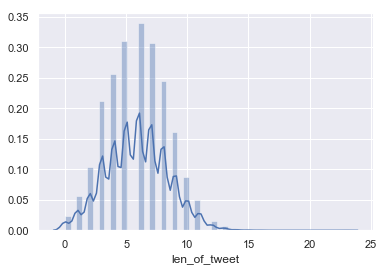

In [52]:
# implement the function across the dataset and save the results in a column
train_data['len_of_tweet'] = train_data['tweets_clean'].map(lengthOfTweet)

# plot a distribution of the tweet lengths
sns.distplot(train_data['len_of_tweet'])
plt.show()

Looks like there is a number of tweets whose length reduces to zero. How many are they?

In [53]:
len(train_data[train_data['len_of_tweet'] == 0])

333

Its only 122 of them, of the more than 15000. Tempting to just drop them and focus on the others. However, this approach has a really high likelyhood of overfitting. I mean the entire process of selecting words almost arbitrarily like this. As such we will treat the paramenter n as a variable parameter and fit a classifier on a cross validation scheme. Note that this will be done later. For now we will do Exploratory Data Analysis, a process that may reveal even more insights about the data/tweets and how they can be utilised to answer some of the question surrounding beief in climate change.

## Exploratory Data Analysis <a class="anchor" id="eigth-bullet"></a>
[back to top](#contents-bullet)

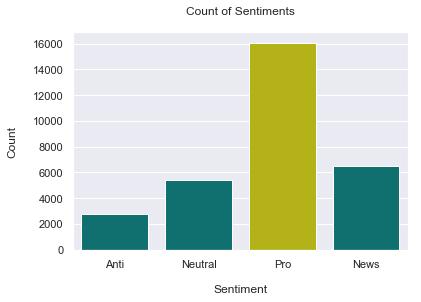

In [54]:
# plotting counter-plots
sns.countplot(data = train_data, x = 'target', palette = {'Pro':'#CCCC00', 'News':'teal', 'Neutral':'teal', 'Anti':'teal'})
plt.title('Count of Sentiments\n')
plt.xlabel('\nSentiment')
plt.ylabel('Count\n')
plt.show()

Looking at the above plot, we see that the data is distributed unevenly across the sentiments. Generally most tweets fall under the Pro class indicating that the general sentiment is that people do believe in human caused climate change. The second most common class is the News class. Note that this is not really a sentiment class but just news articles relating to climate change. The Neutral class consists of a set of tweets whose sentiment indicates that they neither believe nor disbelieve in human caused climate change. Lastly, the Anti class consists of tweeters who make it clear that they do not belive in human caused climate change. In the sample of tweets provided, these are the minority of the population.

### Text analysis
Now we dig a little bit further into the data through use of visualisations and other statistical techniques.

In [55]:
tweet = train_data.loc[0, 'tweets_clean']
tweet

['funny',
 'hell',
 'canada',
 'demand',
 'gender',
 'right',
 'trade',
 'deal',
 'soviet',
 'dairy',
 'board']

**task: plot wordclouds for the different sentiment classes**
A word cloud is essentially a clouds of words. Words that are common will appear bigger than words that appear infrequently in a text document. Lets just go ahead and implement the technique, it will get clear after an illustration. In the code cell below we utilise a python library "wordclod" to generate the words clouds.

In [56]:
# function for generating word cloud
def plotWordCloud(data, label):
    """
    the plot of the most common use of words that appear bigger than words that
    appear infrequent in a text document by each sentiment
    
    Parameters
    ----------
        data (DataFrame): input of dataframe
        label (int): sentiment variable from dataframe
        
    Returns
    -------
        fig (matplotlib.figure.Figure): Final plot to be displayed
    
    """
    words = list()
    for tweet in data['tweets_clean']:
        for token in tweet:
            words.append(token)
    words = ' '.join(words)

    from wordcloud import WordCloud
    wordcloud = WordCloud(contour_width=3, contour_color='steelblue').generate(words)

    # Display the generated image:
    fig = plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label, fontsize = 30)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

Now lets plot a wordcloud for the Pro group. Remember these are tweets that indicate the sentiment of people who believe in climate change. The wordcloud therefore aims to show the words commonly used by those believers. See below.

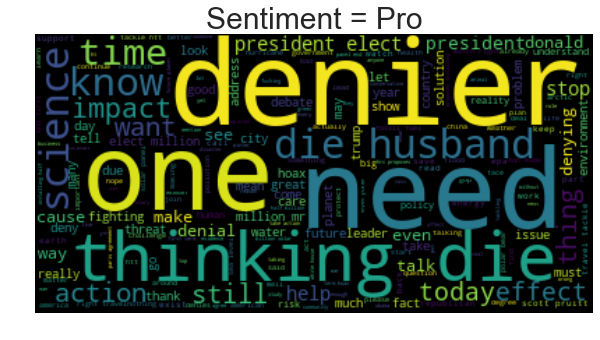

In [57]:
# plotting word cloud for 'Pro' as target
data = train_data[train_data['target'] == 'Pro']
plotWordCloud(data, label = 'Sentiment = Pro')

Generally, this group speaks words like "die", "fight", "husband", "help" etc. Maybe they are scared they will die. They intend to "fight" climate change. Note that they also talk about elections and presidents, maybe they want to be careful when voting for presidents and vote for the candidate that has intentions to fight climate change. See, we can already assume the kinds of statements this group makes just by looking at a wordcloud. They also talk abount "science", "action", maybe they are encouraging that leaders such as presidents should take action. Now let us take a look at the "Anti" group, the non-believers.

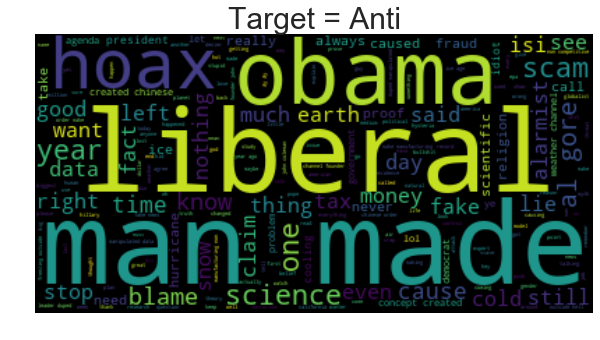

In [58]:
# plotting word cloud for 'Anti' as target
data = train_data[train_data['target'] == 'Anti']
plotWordCloud(data, label = 'Target = Anti')

Looks like this group also talks about "science". They also talk about Obama. It is possible that they are critiquing Obama's views about climate change. Since the data was collected between 2015 and 2018, it is likely that the former president and presidential candidates would be most mentioned in the dataset. Interestingly, and something that is to be expected, this group seeems to use words like "scam", "fake" and "hoax". They just don't believe in climate change and seem to be taken in by conspiracy theories. How about the neutral group. Lets see that wordcloud.

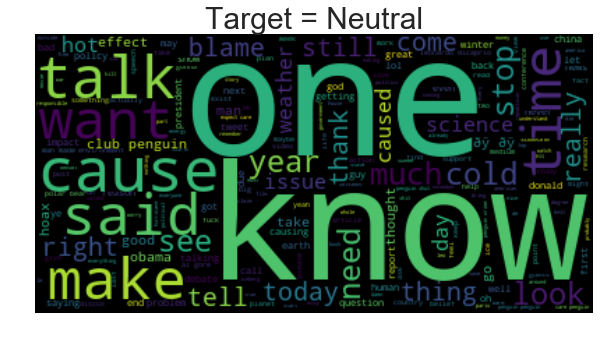

In [59]:
# plotting word cloud for 'Neutral' as target
data = train_data[train_data['target'] == 'Neutral']
plotWordCloud(data, label = 'Target = Neutral')

This group seems to talk about "penguins", "clubs". They share words like "right", "year", "know" with the other sentiment groups. They dont really talk about much. Lets see the news articles

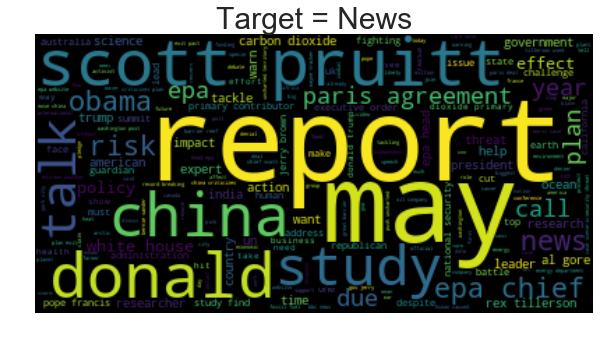

In [60]:
# plotting word cloud for 'News' as target
data = train_data[train_data['target'] == 'News']
plotWordCloud(data, label = 'Target = News')

News articles are generally about politics and current events - Not surprising. Donald Trump is likely mentioned for his anti-climate change beliefs. Scott Pruitt is mentioned as he is the administrator of the Environmental Protection Agency and has been tearing down Obama-era environmental protection policies. China is likely mentioned the most as the largest contributor to greenhouse gas emmisions.

[back to top](#contents-bullet)

### Sentiment analysis
Now we'll ask several more questions about the data. In Natural Language Processing its common to analyse the sentiment of textual data. Sentiment analysis is the automated process that uses AI to analyze data and classify opinions as positive, neutral or negative. Opinions can also be ranked based on how subjective they are. I hope you already see how this may be applicable to the dataset we have been working with. In this sub-section of EDA we intend to analyse the sentiment of our tweets. First we'll we'll implement an algorithm that assigns sentiment scores based of how negative they are or how positive they are. The NLTK library provides such functionality. It generates what they call compound scores that are computed as a linear combination of individual scores for positivity, negativity and neutrality. The higher the compound score the more positive a statement is and vise versa. See the following task for implementation details. As mentioned above opinions can also be ranked based on how subjective they are. We'll then utilise TextBlob, another python NLP package built ontop of NLTK. This package will allow us to easily get sentiment scores for how subjective a certain tweet is. Lets proceed.

###### task: get NLTK Polarity scores
In the code cell below we define a function that gets compound scores from a given text. Note the the text should be in tokenized form (list of words) rather than in raw form.

In [61]:
def getPolarityScores(tweet):
    """
    return the polarity score of each tweet in the dataset
    
    Parameters
    ----------
        tweet (list): list of a tweet
    Returns
    -------
        scores (dict): dictionary of polarity scores
    
    """
    tweet = ' '.join(tweet)
    # analyse the sentiment
    sid = SentimentIntensityAnalyzer()
    # get polarity score of each data
    scores = sid.polarity_scores(tweet) 
    # return the polarity scores
    return scores


# example implementation
print(tweet)
getPolarityScores(tweet)

['funny', 'hell', 'canada', 'demand', 'gender', 'right', 'trade', 'deal', 'soviet', 'dairy', 'board']


{'neg': 0.359, 'neu': 0.471, 'pos': 0.171, 'compound': -0.4939}

Letsgo ahead and implement the function across the dataset. The result is 4 extra columns {negative, neutral, positive and compound). Our interest is mainly in the compound score as it summarises the other three.

In [62]:
# implement the function across the dataset
nltk_scores = dict(compound = list(), negative = list(), neutral = list(), positive = list())
for tweet in train_data['tweets_clean']:
    output = getPolarityScores(tweet)
    nltk_scores['compound'].append(output['compound'])
    nltk_scores['negative'].append(output['neg'])
    nltk_scores['neutral'].append(output['neu'])
    nltk_scores['positive'].append(output['pos'])
    
# concatenate the output from above into the main dataset
if 'compound' in train_data.columns:
    
    # drop the columns if this has been executed before
    train_data.drop(['compound', 'negative', 'neutral', 'positive'], axis = 1, inplace = True)
    
    # concatenate a DataFrame version of the nltk_scores dictionary
    train_data = pd.concat([train_data, pd.DataFrame(nltk_scores)], axis = 1)
else:
    # concatenate directly if this is the first execution
    train_data = pd.concat([train_data, pd.DataFrame(nltk_scores)], axis = 1)

In [63]:
train_data.head(3)

,sentiment,message,tweetid,target,urls,handles,hash_tags,tweets,tweets_clean,len_of_tweet,compound,negative,neutral,positive
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[],"[funny, hell, canada, demand, gender, right, c...","[funny, hell, canada, demand, gender, right, t...",11,-0.4939,0.359,0.471,0.171
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[],"[biggest, lie, climate, change, global, warmin...","[biggest, lie, debunked, one, interview]",5,0.0000,0.000,1.000,0.000
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305,Anti,https://t.co/1dIOrfkslx,[@forbes],"[#Fraud, #Obamacare, #tcot, #teaparty, #pjnet]","[coming, revelation, global, warming, resemble...","[coming, revelation, lie]",3,0.0000,0.000,1.000,0.000


The result is the addiitional columns in our dataset. Lets go ahead and get subjectivity scores from TextBlob before we go on to visualise the scores.

###### task: get TextBlob polarity and subjectivity scores
As mentioined above, textblob will give us a unique set of scores for measuring subjectivity. It also provides what the call polarity scores, that measure sentiments similar to the way NLTK's compound does, although these may differ. See the example below for how textblob works. First we convert a string of text into a blob. The resukting blob has certain attributes and methods it can perform. One of the is computing sentiment scores for subjectivity and polarity by simply averaging the individual sentiment of the words i a string of text. For example "I love the juice" below is said to be a subjective statement. It also ranks high on polarity, it is a positive statement after all.

Next we use a list comprehension to get the sentiment scores, see the cell below.

In [64]:
sentiment_scores = [TextBlob(' '.join(tweet)).sentiment for tweet in train_data['tweets_clean']]

# Add output to dataframe
pol = list()
subj = list()
for scores in sentiment_scores:
    pol.append(scores.polarity)
    subj.append(scores.subjectivity)

train_data['polarity'] = pol
train_data['subjectivity'] = subj

The result of the above operation is 2 additional columns in our dataframe (polarity and subjectivity). At this point we are done. We can go ahead and utilise visualisations to analyse tweet sentiments.

In [65]:
train_data.head(2)

,sentiment,message,tweetid,target,urls,handles,hash_tags,tweets,tweets_clean,len_of_tweet,compound,negative,neutral,positive,polarity,subjectivity
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553,Anti,,[@darreljorstad:],[],"[funny, hell, canada, demand, gender, right, c...","[funny, hell, canada, demand, gender, right, t...",11,-0.4939,0.359,0.471,0.171,0.267857,0.767857
1,-1,All the biggest lies about climate change and ...,925046776553529344,Anti,https://t.co/NgvIPO4wYA,[],[],"[biggest, lie, climate, change, global, warmin...","[biggest, lie, debunked, one, interview]",5,0.0000,0.000,1.000,0.000,0.000000,0.000000


###### task: analyse summary statistics
We'll start off by generating some summary statistics for the 5 new columns we just introduced. See the output displayed below. Compound scores seem to range from -0.96 (minimum) to 0.93 (maximum) suggesting that there are tweets that tend to be highly negative while some tend to be highly positive. The average is -0.05, suggesting that tweet relating to climate change generally tend to contain negativity. Remember polarity captures similar sentiment to compound, also has a wide range (-1 to +1), the mean score however is 0.024, slightly higher that the average compound. Overall however, we expect these will have a high correlation. Subjectivity on the other hand, has a range from 0.26 to 1. The lower this value the more factual the tweet, we expect News tweets will display this characteristic as they report factual information about climate change. The other groups however, particularly the Anti and Pro will probably be very subjective in their statements. We're yet to find out through visualisations.

In [66]:
# summary statistics
train_data[['compound', 'polarity', 'subjectivity']].describe()

,compound,polarity,subjectivity
count,30759.000000,30759.000000,30759.000000
mean,-0.047110,0.025227,0.264262
std,0.379268,0.253360,0.326662
min,-0.965700,-1.000000,0.000000
25%,-0.340000,0.000000,0.000000
50%,0.000000,0.000000,0.066667
75%,0.153100,0.041667,0.500000
max,0.937100,1.000000,1.000000


###### task: visualise the distribution of the score by label
Although the sunmaries in the previous task tell a little story about the data, it does not give us the opprotunity to learn about hos sentiment is distributed across the different classes in our data. Now we want to ask questions such as "Do News tweets tend to be more subjective than tweets by the other groups"? for example. To do this we utilise seaborn's violin plots. Violinplots attempt to show how data is distributed by having fat bellies were more data lies and by thinning in the range where there is little data. An illustration will certainly make this clear. See below.

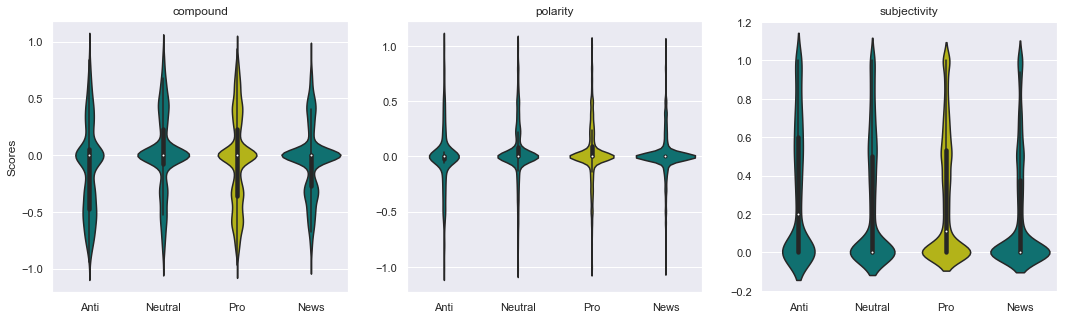

In [67]:
# plotting violin-plots
fig, axes = plt.subplots(1, 3, figsize = (18, 5))
for i, column in enumerate(['compound', 'polarity', 'subjectivity']):
    g = sns.violinplot(data = train_data, x = 'target', y = column, ax = axes[i], palette = {'Pro':'#CCCC00', 'News':'teal', 'Neutral':'teal', 'Anti':'teal'})
    g.set_title(column)
    if column == "compound":
        g.set_ylabel('Scores')
    else:
        g.set_ylabel(' ')
    g.set_xlabel(' ')

### Compound and Polarity

Now looking at the above visual, it is clear that most of the data lies in the same range, ragardless of class. See for example the frist panel, most of the tweets will lie in the zero range of compound scores regardless of whether they are Pro, News or Neutral. The only exception is perhaps the Anti class, the belly in the zero range is smaller and the data is distributed across the range although not evenly. Polarity also displays a similar pattern, much worse. An important aspect of violinplots are the white dots we see in the middle of the bellies. That is the median value of the scores in that class. See that the median scores are relatively the same for both compound and polarity scores. Finally, looking at the colours of the visuals. The coloring is intentinal. If we are to extract insights about how people perceive climate change and whether or not they believe it is real, having sample data on belief we know for sure believe in climate cahnge is a good starting point. Thats why the Pro group is colored differently from the rest. The task now becomes one of figuring out how significantly different is the sample data of the other groups from that of the Pro group. Based on these violin plots for compound and polarity we can't tell. Lets look at subjectivity, the third panel of the figure.

### Subjectivity

Looking at subjectivity, the belly curve dont really tell anything. But look at the white dots (median), its slightly higher for the Pro and the Anti group. Note that these are people with strong opinions about climate change, very surprising that they are so subjective. News tweets as per our hypothesis earlier they are lower on subjectivity, and so are the Neutral group tweets. Perhaps now we have something to go on. But then again, how significant are these differences, can we possibly quantify that difference. In a later section we'll attempt testing a hypothesis based on t-tests on the mean values of the different classes.

##### task: visualise sentiment scores in a 2 dimensional space
In this task we take the average scores for each group and visualise them in two dimensional spaces. The idea is to visusally inspect how different the scores for Anti, News and Neutral are from the Pro class. This should give us a rough idea of how people perceive climate change relative to the believers. The following code cell utilises the groupby method to get the averages.

In [68]:
data = train_data.groupby('target')[['negative', 'positive', 'neutral', 'compound', 'polarity', 'subjectivity']].mean().reset_index()
data

,target,negative,positive,neutral,compound,polarity,subjectivity
0,Anti,0.231218,0.126438,0.634470,-0.123838,-0.007347,0.317631
1,Neutral,0.131142,0.153661,0.677977,0.017709,0.047847,0.261593
2,News,0.145263,0.101391,0.752423,-0.051856,0.015011,0.193723
3,Pro,0.194754,0.151835,0.646943,-0.053637,0.027415,0.284380


In [69]:
# function for generating scatter-plot
def plotScatter(x, y, df, title):
    """
    display the scatter plot
    
    Parameters
    ----------
        x (str): variable string from dataframe
        y (str): variable string from dataframe
        df (DataFrame): input of dataframe
        
    Returns
    -------
        g (plot): display a scatter plot with points of each labelled sentiments
    
    """
    fig = plt.figure(figsize = (8, 5))
    g = sns.scatterplot(data = df, x = x, y = y, hue = 'target', legend = False, palette = {'Pro':'#CCCC00', 'News':'teal', 'Neutral':'teal', 'Anti':'teal'})
    g.set_title(title, fontsize = 20)
    
    # add annotations one by one with a loop
    for line in range(0,data.shape[0]):
        g.text(data[x][line], data[y][line], data['target'][line], 
                horizontalalignment='left', size='large', color='black')
    
    return g

We'll start off by plotting compound versus polarity in a two dimensional space. We then indicate where in that space each class would lie based on their computed average values of sentiment. Looking at the figure, it is clear that the News tweets tend to perceive climate change almost similar to the way the Pro group does. The Anti group is a little further. The Neutral group is furthest. An additional finding is that, in a spectrum that goes from negative to positive, both Pro and News fall somewhere inbetween. With the Anti group being the most negative and the Neutral group being the most positive.

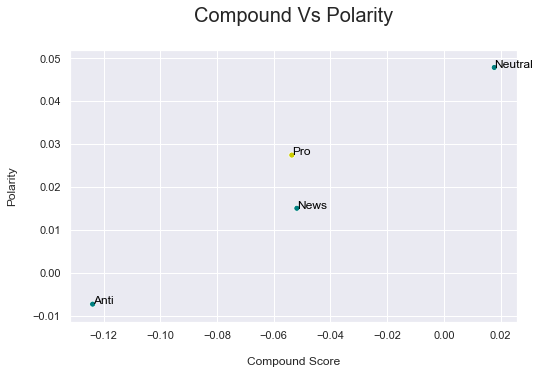

In [70]:
# plotting scatter-plot
plotScatter(x = 'compound', y = 'polarity', df = data, title = 'Compound Vs Polarity\n')
plt.xlabel('\nCompound Score')
plt.ylabel('Polarity\n')
plt.show()

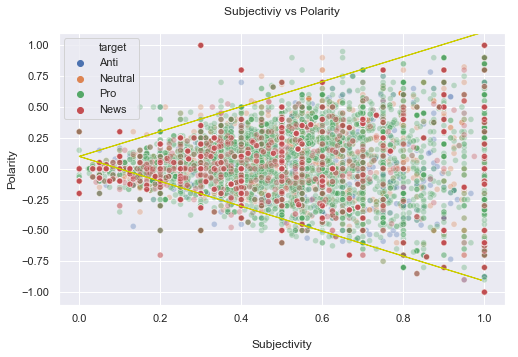

In [71]:
# plotting scatter-plot
fig = plt.figure(figsize = (8, 5))
g = sns.scatterplot(data = train_data, x = 'subjectivity', y = 'polarity', color = 'teal', hue = 'target', alpha = 1/3)
g.arrow(0, 0.1, 0.99, 1, fc = 'black', ec = '#CCCC00')
g.arrow(0, 0.1, 0.99, -1, fc = 'black', ec = '#CCCC00')
plt.title('Subjectiviy vs Polarity\n')
plt.xlabel('\nSubjectivity')
plt.ylabel('Polarity')
plt.show()

In [72]:
# plotting scatter-plot 
# plotScatter(x = 'subjectivity', y = 'polarity', df = data)

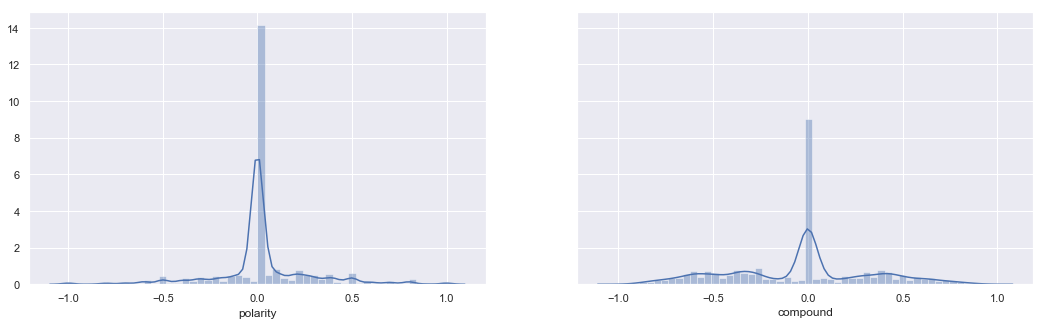

In [73]:
# plotting histogram and line on it
columns = ['polarity', 'compound']
fig, axes = plt.subplots(1, len(columns), figsize = (18, 5), sharey = True)
for i, column in enumerate(columns):
    sns.distplot(train_data[column], ax = axes[i])

In [74]:
# variables of columns from dataframe that are conditioned to zero
polarity_mask = train_data['polarity'] == 0
compound_mask = train_data['compound'] == 0

# check the length of polarity_mask and compound _mask from the dataframe
len(train_data[polarity_mask]), len(train_data[compound_mask])

(17161, 10520)

In [75]:
# check a length on condition of polarity_mask & compound_mask
len(train_data[polarity_mask & compound_mask])

7778

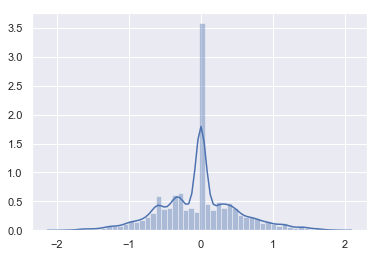

In [76]:
#plotting histigram and line on it
sum_of_pol_and_comp = train_data['polarity'].add(train_data['compound'])
sns.distplot(sum_of_pol_and_comp)

In [77]:
# create new column
train_data['pol_plus_comp'] = sum_of_pol_and_comp

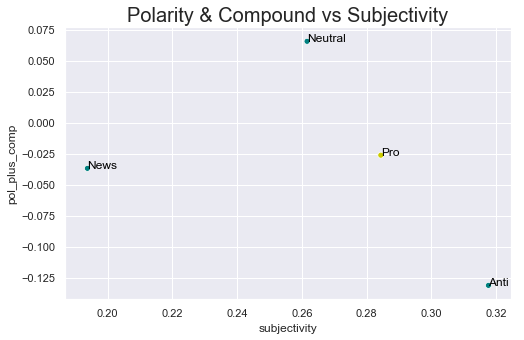

In [78]:
#plotting scatter-plot
data = train_data.groupby('target')[['pol_plus_comp', 'subjectivity']].mean().reset_index()
plotScatter(x = 'subjectivity', y = 'pol_plus_comp', df = data, title="Polarity & Compound vs Subjectivity")
plt.show()

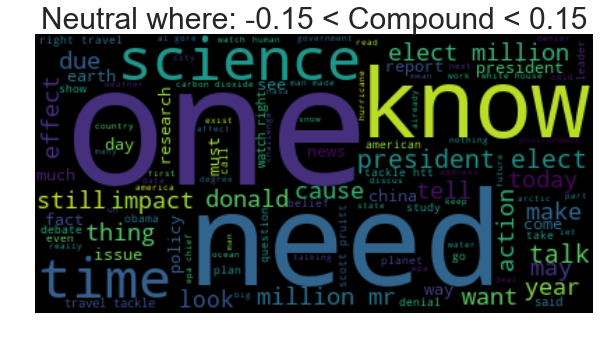

In [79]:
#plotting word cloud
lower = -0.15
interval = 0.3
data = train_data[(train_data['compound'] < lower+interval) & (train_data['compound'] > lower)]
plotWordCloud(data, label = f'Neutral where: {lower} < Compound < {lower+interval}')

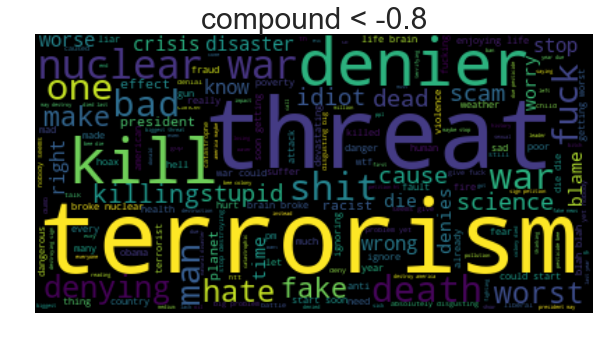

In [80]:
# plotting word cloud
lower = -0.8
data = train_data[train_data['compound'] < lower]
plotWordCloud(data, label = f'compound < {lower}')

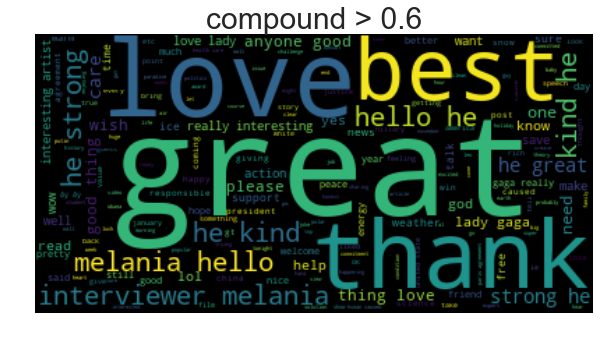

In [81]:
# plotting word cloud
upper = 0.6
sent = 0
data = train_data[(train_data['sentiment']==sent)&(train_data['compound'] > upper)]
plotWordCloud(data, label = f'compound > {upper}')

## Modelling  <a class="anchor" id="ninth-bullet"></a>
[back to top](#contents-bullet)

### Dealing with data imbalances

As we saw in our EDA, the dataset is imbalanced as more than 50% of the observations belong to the `Pro`class and the fewest observations belonging to the `Anti` class. Although the dataset is representative of the the population, it is not usefull for modelling as our model will perform well on the `Pro` class but poorly for the `Anti` class. We have chose to resample our dataset to 50% of the `Pro` class. This will cause worse performance on the `Pro` subset as we will lose 4000 observations, however we may see an improvement in the classes with fewer observations

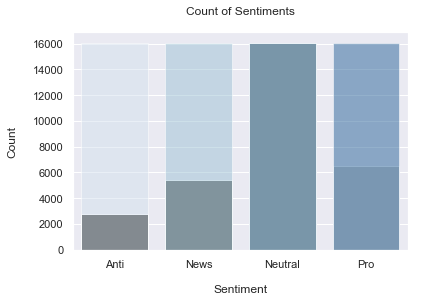

In [82]:
# Setting the random_state to reproduce the same results
rs = 42

#Creating data subsets
pos = train_data[train_data['sentiment']==1]
neg = train_data[train_data['sentiment']==-1]
neu = train_data[train_data['sentiment']==0]
news = train_data[train_data['sentiment']==2]

# Class size
frac = 100
size = int(len(pos)* frac/100)

# Resampling
neg_upsampled = resample(neg,

                          replace=True, # sample with replacement (need to duplicate observations)
                          n_samples=size, # match number in half of majority class
                          random_state=rs) # reproducible results

news_upsampled = resample(news,
                          replace=True, # sample with replacement (need to duplicate observations)
                          n_samples=size, # match number in half of majority class
                          random_state=rs) # reproducible results

neu_upsampled = resample(neu,
                          replace=True, # sample with replacement (need to duplicate observations)
                          n_samples=size, # match number in half of majority class
                          random_state=rs) # reproducible results

pos_downsampled = resample(pos,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=size, # match number in half of majority class
                          random_state=rs) # reproducible results

sampled = pd.concat([neg_upsampled, news_upsampled, neu_upsampled, pos_downsampled])

# Display new class counts

sns.countplot(data = train_data, x = 'target', palette = 'gray')
sns.countplot(data = sampled, x = 'target', palette = "Blues", alpha=0.5)
plt.title('Count of Sentiments\n')
plt.xlabel('\nSentiment')
plt.ylabel('Count\n')
plt.show()

### Train Test Split

In [83]:
#consider also using 'compound' column
X = sampled['tweets_clean'].apply(lambda x:' '.join(x))
y = sampled['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs)

### Cross-Validation

In order to choose a model we need to determine which is the besst classifier for the job. To do this, the function below will:
1. Cross validate the models - Default folds = 2
2. Build a pipeline
2. Fit and tune the model hyperparameters
3. Return a dataframe containing the pipeline, models and results

In [84]:
def best_classifier (param_search,vectoriser, cv_folds):

    """
    Return a dataframe including, and ranking, the weighted f1 scores
    of the classifiers (from input), using the best parameters 
    (from GridSearch performed on input parameters) after being run through
    a pipeline with the input vectoriser.

    Creates a dictionary in the form:
    {'name of classifier':'classifier with best parameters'}

    Parameters:
    param_search -- a list of tuples, in the form
                  [(name of classifier,classifier,param_grid)]
    vectoriser -- word vectoriser
    """

  # Creates empty dictionary to store classifier with best parameters
    class_dict = {}
  # New list to append information from classifer gridsearch
    results = []

  # Gridsearching each classifier in provided list
    for i in param_search:
        pipe = Pipeline([('vectorizer', vectoriser),
                         ('classifier', i[1])])
    
        grid = GridSearchCV(pipe,i[2],scoring='f1_weighted',n_jobs=-1, cv=cv_folds, verbose=2)
        grid.fit(X_train,y_train)

  # Making prediction on test set data using classifier fitted with best parameters
        y_pred = grid.best_estimator_.predict(X_test)
  
  # Appending tuple of information gained from grid search to results list
        results.append([i[0],f1_score(y_test,y_pred, average='weighted'),
                        grid.best_params_])
        
# Converting name string for naming file
        key = i[0].lower().replace(' ','_')
  # Adding classifier, loaded with best parameters, to dictionary   
        class_dict[key] = [grid.best_estimator_,
                            f1_score(y_test,y_pred, average='weighted')]

  # Creating dataframe to display sorted f1_scores
    results = pd.DataFrame(results, columns=['classifier','f1_score',
                                         'best_params'])
    results.set_index(['classifier'], inplace=True)
    results = results.sort_values('f1_score', ascending=False)
    return class_dict, results

In order to execute our best_classifier function, we must create the following variables to feed into the function

In [85]:
# Instantiate a vectorizer
vectoriser = TfidfVectorizer()

# Name all of the classifiers
names = ['Multi-layer Perceptron','Logistic Regression',
         'Nearest Neighbors',
         'AdaBoost',
         'Naive Bayes',
         'Decision Tree', 
         'Support Vector',
         'Random Forest'
        ]

# Instatiate the classifiers
classifiers = [MLPClassifier(verbose=True),LogisticRegression(),
               KNeighborsClassifier(),
               AdaBoostClassifier(),
               MultinomialNB(),
               DecisionTreeClassifier(),
               SVC(),
               RandomForestClassifier(),
               
              ]

# List model parameters
params = [{'classifier__epsilon': [1e-06,1e-08,1e-10],
#            'classifier__hidden_layer_sizes': [(100,),(100,1)],
           'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
           'classifier__solver': ['lbfgs', 'sgd', 'adam']},
          {'classifier__C':[0.001, 0.01, 0.1, 1, 10],
           'classifier__solver':['liblinear','sag','saga','lbfgs'],
           'classifier__max_iter':[500, 1000]},
          {'classifier__n_neighbors':[1, 5, 10],
           'classifier__weights':['uniform','distance'],
           'classifier__algorithm':['auto', 'brute']},
          {'classifier__n_estimators':[50, 100, 500, 1000],
           'classifier__algorithm':['SAMME','SAMME.R']},
          {'classifier__alpha':[0.01,0.5,1],
           'classifier__fit_prior':[True, False]},
          {'classifier__criterion':["gini", "entropy"],
           'classifier__splitter':['best','random']},
          {'classifier__C':[0.1, 1, 10],
           'classifier__kernel':['poly', 'rbf', 'sigmoid'],
           'classifier__gamma':[0.1, 1]},
          {'classifier__n_estimators':[10, 100, 500],
           'classifier__criterion':['gini', 'entropy']},
          
         ]

In [ ]:
class_dict, results = best_classifier(zip(names,classifiers,params),vectoriser,5)
results

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


### Model Scoring

Let us now inspect our best models (Support Vector Machine and Random Forest) with

### To Comet

In [ ]:
# For each model
for name, ppl in class_dict.items():
    # Record Metrics
    y_pred = ppl[0].predict(X_test)
    f1 = f1_score(y_test,y_pred, average='weighted')
    precision = precision_scorescore(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    metrics = {'f1':f1,
              'recall':recall,
              'precision':precision}
    # Enter paramerters
    params = {"random_state":rs,
              "model_type":"",
              "scaler":"",
              "param_grid":"",
              "stratify":""}
    # Enter
    metrics = {"f1":f1,
               "precision":precision,
               "recall":recall}
    experiment.log_metric(metrics)
    experiment.log_parameter(params)

In [ ]:
experiment.end()

### Saving Models as .pkl Files

In [ ]:
for name, classifier in class_dict.items():
# Saving models with best parametres for use in streamlit app
    model_save_path = f"{name}.pkl"
    with open(model_save_path, 'wb') as file:
        pickle.dump(classifier[0],file)

### Processsing Test Data

In [ ]:
test_data = test_data.copy()
test_data = typeConvert(test_data[['message', 'tweetid']])
test_data['urls'] = test_data['message'].map(findURLs)
test_data = strip_url(test_data)
test_data['handles'] = test_data['message'].map(findHandles)
test_data['hash_tags'] = test_data['message'].map(findHashTags)
test_data['tweets'] = test_data['message'].map(removePunctuation)
test_data['tweets'] = test_data['tweets'].map(tweetTokenizer)
test_data['tweets'] = test_data['tweets'].map(removeStopWords)
test_data['tweets'] = test_data['tweets'].map(lemmatizeTweet)
test_data['tweets_clean'] = test_data['tweets'].map(lambda tweet: removeInfrequentWords(tweet, include = top_n_words + class_specific_words))
test_data['tweets_clean'] = test_data['tweets_clean'].map(removeCommonWords)
test_data['len_of_tweet'] = test_data['tweets_clean'].map(lengthOfTweet)
nltk_scores = dict(compound = list(), negative = list(), neutral = list(), positive = list())
for tweet in test_data['tweets_clean']:
    output = getPolarityScores(tweet)
    nltk_scores['compound'].append(output['compound'])
    nltk_scores['negative'].append(output['neg'])
    nltk_scores['neutral'].append(output['neu'])
    nltk_scores['positive'].append(output['pos'])
    
if 'compound' in test_data.columns:
    test_data.drop(['compound', 'negative', 'neutral', 'positive'], axis = 1, inplace = True)
    test_data = pd.concat([test_data, pd.DataFrame(nltk_scores)], axis = 1)
else:
    test_data = pd.concat([test_data, pd.DataFrame(nltk_scores)], axis = 1)
    
sentiment_scores = [TextBlob(' '.join(tweet)).sentiment for tweet in test_data['tweets_clean']]

pol = list()
subj = list()
for scores in sentiment_scores:
    pol.append(scores.polarity)
    subj.append(scores.subjectivity)

test_data['polarity'] = pol
test_data['subjectivity'] = subj
sum_of_pol_and_comp = test_data['polarity'].add(test_data['compound'])
test_data['pol_plus_comp'] = sum_of_pol_and_comp

test_data.head()

In [ ]:
experiment.end()

### Predictions on Test Set

In [ ]:
X_sub = test_data['tweets_clean'].apply(lambda x:' '.join(x))


In [ ]:
sub_classifier = sorted(class_dict.items(), key=lambda x:x[1][1], reverse=True)
sub_classifier = sub_classifier[0]
sub_classifier = sub_classifier[1][0]

sample_data['sentiment'] = sub_classifier.predict(X_sub)
sample_data.set_index('tweetid', inplace=True)

sample_data.to_csv('submission.csv')

In [ ]:
sample_data.head()

### Submitting directly to Competition

In [ ]:
# Install required libraries
!pip install --upgrade pip
!pip install kaggle --upgrade

In [ ]:
%mkdir --parents /root/.kaggle/
%cp /kaggle/input/kaggle-token/kaggle.json   /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit -c climate-change-belief-analysis -f submission.csv -m "new submission"

[back to top](#contents-bullet)

## Conclusion <a class="anchor" id="tenth-bullet"></a>